In [1]:
%cd /content/drive/MyDrive/Github/FL-project

/content/drive/MyDrive/Github/FL-project


In [2]:
from main import *
import argparse
from centralized import Centralized
from client import *

In [3]:
class Args():
  def __init__(self, dataset, model, bs, hnm, num_epochs):
    self.dataset = dataset
    self.model = model 
    self.bs = bs
    self.hnm = hnm
    self.num_epochs = num_epochs

args = Args('iddaCB', model = 'deeplabv3_mobilenetv2', bs = 16, hnm = True, num_epochs = 15)

In [4]:
trainAloneDataset, testAloneDatasets = get_datasets(args)
ds = trainAloneDataset[0]

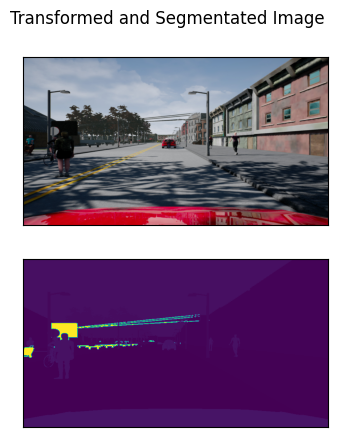

In [5]:
ds.showImgAndLable(2)

In [6]:
#istanziamo il modello 
model = model_init(args)

In [7]:
centralized = Centralized(args,ds,model)
state_dict = torch.load('modelliSalvati/checkpoint.pth')
model.classifier.load_state_dict(state_dict)
#centralized.train()

<All keys matched successfully>

In [8]:
from utils.stream_metrics import StreamSegMetrics
metric = StreamSegMetrics(16, 'centralizzato')
centralized.test(metric)

KeyboardInterrupt: ignored

In [9]:
metric.get_results()['Mean IoU']

0.0013109556663038855

In [10]:
from torch.utils.data import DataLoader
train_loader = DataLoader(ds, batch_size = 2, shuffle = False, drop_last = True)

In [11]:
centralized.model.eval()
with torch.no_grad():
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda() 
    labels = labels.cuda()
    outputs = centralized.model(images)['out']
    break

In [12]:
outputs = centralized.model(images[1].view(1, 3, 512, 928))['out']

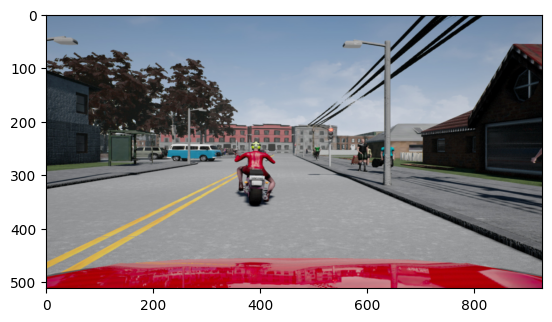

In [13]:
import matplotlib.pyplot as plt
def unNormalize(tensorImage, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        for t, m, s in zip(tensorImage, mean, std):
            t.mul_(s).add_(m)
        return tensorImage
plt.imshow(unNormalize(images[1].cpu()).permute(1,2,0))

In [14]:
singoloOutputLogits = outputs[0]
prediction = singoloOutputLogits.argmax(0)

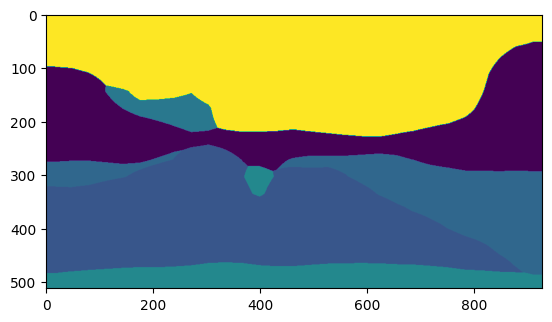

In [15]:
import matplotlib.pyplot as plt
plt.imshow(unNormalize(images[1].cpu()).permute(1,2,0))
plt.imshow(prediction.cpu().numpy(), alpha = 1)

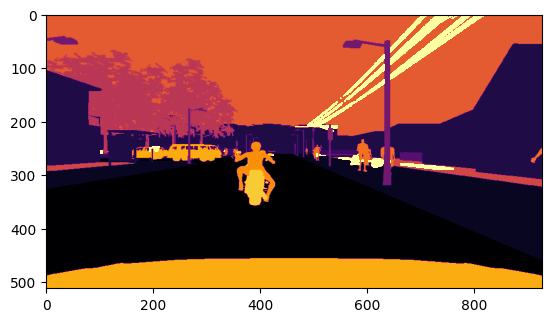

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.imshow(labels[1].cpu().numpy(), cmap = mpl.colormaps['inferno'], vmin = 0, vmax = 16)

In [17]:
def idda_16_cmap(n=256):
    color = [[128, 64, 128],
             [244, 35, 232],
             [70, 70, 70],
             [102, 102, 156],
             [190, 153, 153],
             [153, 153, 153],
             [250, 170, 30],
             [220, 220, 0],
             [107, 142, 35],
             [152, 251, 152],
             [70, 130, 180],
             [220, 20, 60],
             [255, 0, 0],
             [0, 0, 142],
             [0, 0, 230],
             [119, 11, 32],
             [0, 0, 0]]
    cmap = np.zeros((n, 3), dtype='uint8')
    for i, co in enumerate(color):
        cmap[i] = co
    return cmap.astype(np.uint8)


class Label2Color(object):
    def __init__(self, cmap):
        self.cmap = cmap

    def __call__(self, lbls):
        return self.cmap[lbls]

In [20]:
label2color = Label2Color(idda_16_cmap())

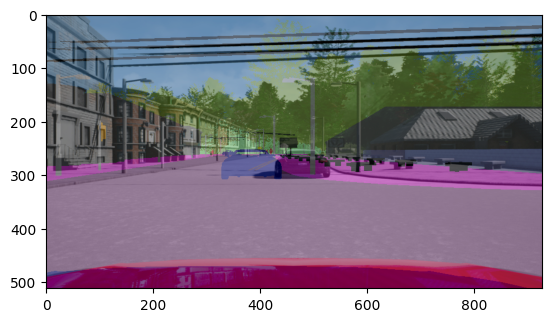

In [21]:
import numpy as np
img = ds[0][0].cuda()
outputLogit = centralized.model(img.view(1, 3, 512, 928))['out'][0]
prediction = outputLogit.argmax(0)
label2color = Label2Color(idda_16_cmap())
#pred_mask = label2color(prediction.cpu()).astype(np.uint8)
target = ds[0][1]
true_mask = label2color(target).astype(np.uint8)
plt.imshow(unNormalize(img.cpu()).permute(1,2,0))
#plt.imshow(pred_mask, alpha = 1)
plt.imshow(true_mask, alpha = .4)

In [22]:
prediction

tensor([[ 0,  0,  0,  ..., 15, 15, 15],
        [ 0,  0,  0,  ..., 15, 15, 15],
        [ 0,  0,  0,  ..., 15, 15, 15],
        ...,
        [ 7,  7,  7,  ...,  7,  7,  7],
        [ 7,  7,  7,  ...,  7,  7,  7],
        [ 7,  7,  7,  ...,  7,  7,  7]], device='cuda:0')

In [23]:
target

tensor([[10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10],
        ...,
        [13, 13, 13,  ...,  0,  0,  0],
        [13, 13, 13,  ...,  0,  0,  0],
        [13, 13, 13,  ...,  0,  0,  0]])

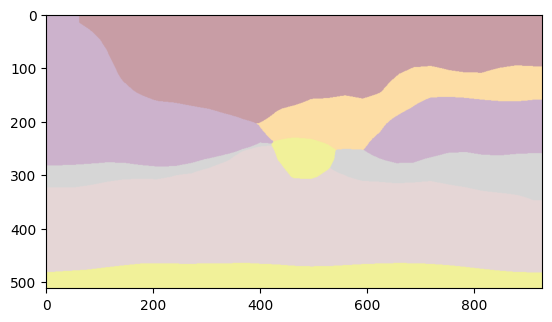

In [24]:
pred_mask = label2color(prediction.cpu()).astype(np.uint8)
plt.imshow(pred_mask, alpha = 0.4)

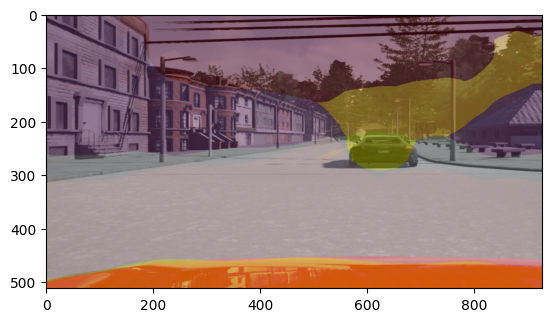

In [25]:
import numpy as np
img = ds[0][0].cuda()
outputLogit = centralized.model(img.view(1, 3, 512, 928))['out'][0]
prediction = outputLogit.argmax(0)
label2color = Label2Color(idda_16_cmap())
pred_mask = label2color(prediction.cpu()).astype(np.uint8)
plt.imshow(unNormalize(img.cpu()).permute(1,2,0))
plt.imshow(pred_mask, alpha = 0.4)

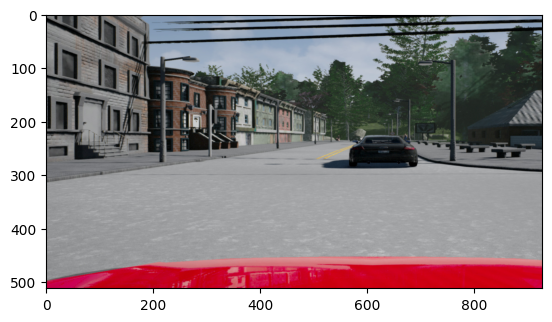

In [26]:
plt.imshow(unNormalize(img.cpu()).permute(1,2,0))

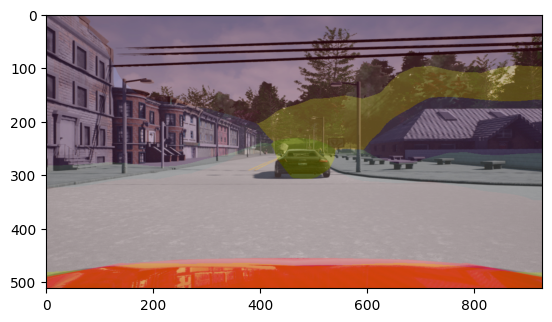

In [27]:
centralized.checkImageAndPrediction(0, 0.3)